## Understand

The sections "Background" and "The Mailing Experiment" are provided as context for the business challenge. 

**Background**

Takyo is a software catalog firm that sells games and educational software. It started out as a software manufactuer and later added third-party titles to its offerings. It has recently put together a revised collection of items in a new catalog, which it is preparing to roll out in a mailing. 

In addition to its own software titles, Tayko's customer list is a key asset. In an attempt to expand its customer base, it has recently joined a consortium of catalog firms that specialize in computer and software products. The consortium affords members the opportunity to mail catalogs to names drawn from a pooled list of customers. Members supply their own customer lists to the pool, and can "withdraw" an equivalent number of names each quarter. Members are allowed to do predictive modeling on the records in the pool so they can do a better job of selecting names from the pool. 

NOTE: Although Tayko is a hypothetical company, the data in this case (modified slightly for illustrative purposes) were supplied by a real company that sells software through direct sales. The concept of a catalog consortium is based on the Abacus Catalog Alliance. 

**The Mailing Experiment**

Tayko has supplied its customer list of 200,000 names to the pool, which totals over 5,000,000 names, so it is now entitled to draw 200,000 names for a mailing. Tayko would like to select names that have the best chance of performing well, so it conducts a test -- it draws 20,000 names from the pool and does a test mailing of the new catalog. 

This mailing yielded 1065 purchasers, a response rate of 5.3%. To optimize the performance of the data mining techniques, it was decided to work with a stratified sample that contained equal numbers of purchasers and nonpurchasers. For ease of presentation, the dataset for this case includes just 1000 purchasers and 1000 nonpurchasers, an apparent response rate of 50%. Therefore, after using the dataset to predict who will be a purchaser, we must adjust the purchase rate back down by multiplying each case's "probability of purchase" by 5.3%/50% (or 0.107).

**Objectives**

Each catalog costs approximately \$2 to mail (including printing, postage, and mailing costs). The goal of the analysis will be to determine how to maximize the expected profit of sending catalogs to the remaining 180,000 names that Tayko can select from the consortium database. 

To achieve the objective of maximizing revenue, we will:
1. Estimate the gross profit if Tayko selected the remaining 180,000 records at random
2. Develop a model for classifying the propability of purchase for each customer (adjusted for oversampling purchasers)
3. Develop a model for predicting the spend of each customer's purchase
4. Calculate the expected value of each customer by multiplying the probability of purchase by the predicted spend
5. Estimate the gross profit that would result from using the predictive models for selecting the remaining 180,000 names from the catalog database

Performance of individual models will be measured using the accuracy for the classification task (since our sample is split 50/50) and RMSE for the prediction task. Overall, success will be measured by an increase of 20% in the expected gross profit of sending catalogs to customers using the predictive pipeline compared to completely at random. 

**Deployment**

If the predictive analytics solution is deemed successful, the resulting models will be used to score customers before the next sendout. Customers will be pulled from the database and scored offline before being selected for the next mailing. 

## Theorize

**Data**

The dataset for the business analytics task is provided by the catalog constorium and contains 1000 purchasers and 1000 nonpurchasers with 25 total variables:
+ Sequence number (psedo customer ID)
+ US address (Y/N)
+ Source catalog for the record (15 variables)
+ Number of transactions last year in source catalog
+ Days last update was made to customer record
+ Days ago first update was made
+ Previous Web Order (Y/N)
+ Gender
+ Address is residential (Y/N)
+ Purchase in test mailing (Y/N)
+ Spend in test mailing (dollars)

In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

sns.set(color_codes = True)
sns.set(style = "white")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [300]:
# sequence number is a customer identifier
tayko = pd.read_csv('data/raw/Tayko.csv', index_col = 'sequence_number')

We can confirm that there are no missing values and the data only contains numeric values.

In [301]:
tayko.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 24 columns):
US                      2000 non-null int64
source_a                2000 non-null int64
source_c                2000 non-null int64
source_b                2000 non-null int64
source_d                2000 non-null int64
source_e                2000 non-null int64
source_m                2000 non-null int64
source_o                2000 non-null int64
source_h                2000 non-null int64
source_r                2000 non-null int64
source_s                2000 non-null int64
source_t                2000 non-null int64
source_u                2000 non-null int64
source_p                2000 non-null int64
source_x                2000 non-null int64
source_w                2000 non-null int64
Freq                    2000 non-null int64
last_update_days_ago    2000 non-null int64
1st_update_days_ago     2000 non-null int64
Web order               2000 non-null int64
Gender=male  

In [302]:
tayko.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
US,2000.0,0.82,0.38,0.0,1.00,1.0,1.00,1.0
source_a,2000.0,0.13,0.33,0.0,0.00,0.0,0.00,1.0
source_c,2000.0,0.06,0.23,0.0,0.00,0.0,0.00,1.0
source_b,2000.0,0.06,0.24,0.0,0.00,0.0,0.00,1.0
source_d,2000.0,0.04,0.20,0.0,0.00,0.0,0.00,1.0
source_e,2000.0,0.15,0.36,0.0,0.00,0.0,0.00,1.0
source_m,2000.0,0.02,0.13,0.0,0.00,0.0,0.00,1.0
source_o,2000.0,0.03,0.18,0.0,0.00,0.0,0.00,1.0
source_h,2000.0,0.05,0.22,0.0,0.00,0.0,0.00,1.0
source_r,2000.0,0.07,0.25,0.0,0.00,0.0,0.00,1.0


We see most of the customers in our sample come from sources E and W, majority have US addresses, do not have residential addresses, and have made 1-2 purchases. 

**Objective \#1**

We see that the average spend of a customer in the test send is \\$102.62. What is the expected gross profit if we send catalogs to 180k random customers and 5.3% respond with an average purchase of \\$102.62 (though this includes non-spenders)?

In [303]:
# test response rate
response_rate = 1065 / 20000
# avergae spend of those that responded
avg_spend = tayko[tayko['Purchase'] == 1]['Spending'].mean()
# next sendout size
sendout_size = 180000
# cost in $ of mailing
sendout_cost = 2
# objective ROI increase of data mining task
roi_increase = .2

random_gross_profit = (sendout_size * response_rate * avg_spend) - (sendout_size * sendout_cost)
print(f"The total expected gross profit of a random sendout is ${np.round(random_gross_profit, 2)}")
print(f"The expected gross profit per customer is ${np.round(random_gross_profit / sendout_size, 2)}")
print()

objective_gross_profit = random_gross_profit * (1 + roi_increase)
print(f"Our objective will be to deliver an expected gross profit of ${np.round(objective_gross_profit, 2)}")
print(f"Our objective gross profit per customer is ${np.round(objective_gross_profit / sendout_size, 2)}")

The total expected gross profit of a random sendout is $1607311.66
The expected gross profit per customer is $8.93

Our objective will be to deliver an expected gross profit of $1928774.0
Our objective gross profit per customer is $10.72


**Notes:**

+ We can contact about 3.6% of the remaining customers (180k / 4.98 million). 
+ If we can increase the expected profit per customer in the top 5% of customers in the test set to \\$10.72, we will achieve the goal. 

#### Data Partition

In [328]:
# split into train and test sets
from sklearn.model_selection import train_test_split

targets = ['Spending', 'Purchase']
features = [x for x in tayko.columns if x not in targets]

X_train, X_test, y_train, y_test = train_test_split(
    tayko[features], tayko[targets], test_size = 0.25, random_state = 42
)

print(f"Features: \n{features}")
print()
print(f"Targets: \n{targets}")
print()
print(f"Training Set: {X_train.shape[0]} rows and {X_train.shape[1]} features")
print(f"Testing Set: {X_test.shape[0]} rows and {X_test.shape[1]} features")

Features: 
['US', 'source_a', 'source_c', 'source_b', 'source_d', 'source_e', 'source_m', 'source_o', 'source_h', 'source_r', 'source_s', 'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Freq', 'last_update_days_ago', '1st_update_days_ago', 'Web order', 'Gender=male', 'Address_is_res']

Targets: 
['Spending', 'Purchase']

Training Set: 1500 rows and 22 features
Testing Set: 500 rows and 22 features


In [329]:
print("Train")
print(y_train['Purchase'].value_counts())
print()
print("Test")
print(y_test['Purchase'].value_counts())

Train
0    757
1    743
Name: Purchase, dtype: int64

Test
1    257
0    243
Name: Purchase, dtype: int64


Let's confirm that our train and test splits do not have statistically different proportions of purchasers and/or mean spending. In this sense, higher p-values will confirm there is not a low chance they contain different distributions.

In [330]:
import statsmodels.api as sm

train_prop = y_train['Purchase'].value_counts()
test_prop = y_test['Purchase'].value_counts()

# confirm Purchase distribution is similar
z_score, p_value = sm.stats.proportions_ztest(
    count = [train_prop[1], test_prop[1]], 
    nobs = [train_prop.sum(), test_prop.sum()]
)

print(f"Purchasers p-value: {p_value:.2f}")

Purchasers p-value: 0.47


In [331]:
from scipy import stats

# confirm spending distribution is similar
t_stat, p_value = stats.ttest_ind(
    y_train['Spending'], 
    y_test['Spending'], 
    equal_var = False
)

print(f"Spending p-value: {p_value:.2f}")

Spending p-value: 0.69


In [332]:
X_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
US,1500.0,0.82,0.38,0.0,1.0,1.0,1.00,1.0
source_a,1500.0,0.12,0.33,0.0,0.0,0.0,0.00,1.0
source_c,1500.0,0.05,0.23,0.0,0.0,0.0,0.00,1.0
source_b,1500.0,0.06,0.25,0.0,0.0,0.0,0.00,1.0
source_d,1500.0,0.04,0.20,0.0,0.0,0.0,0.00,1.0
source_e,1500.0,0.16,0.37,0.0,0.0,0.0,0.00,1.0
source_m,1500.0,0.02,0.12,0.0,0.0,0.0,0.00,1.0
source_o,1500.0,0.03,0.18,0.0,0.0,0.0,0.00,1.0
source_h,1500.0,0.05,0.22,0.0,0.0,0.0,0.00,1.0
source_r,1500.0,0.07,0.25,0.0,0.0,0.0,0.00,1.0


In [333]:
y_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Spending,1500.0,101.65,187.05,0.0,0.0,0.0,150.0,1500.0
Purchase,1500.0,0.50,0.50,0.0,0.0,0.0,1.0,1.0


#### Visualize

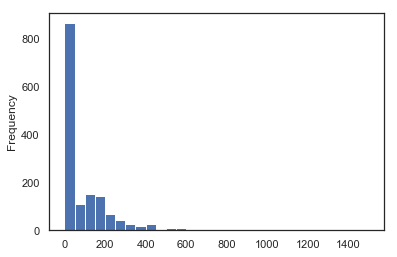

In [334]:
# visualize spending target
y_train['Spending'].plot(kind = 'hist', bins = 30);

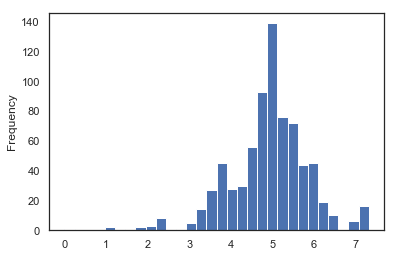

In [335]:
spenders = y_train['Spending'] > 0

np.log(y_train[spenders]['Spending']).plot(kind = 'hist', bins = 30);

The spend distribution confirms that we will want to log-transform our spend variable in our modeling step.

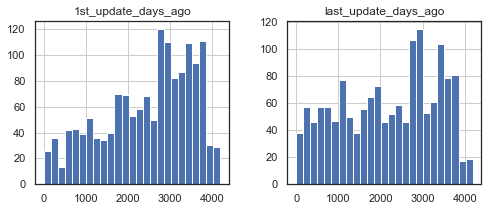

In [336]:
days_cols = [x for x in X_train.columns if 'days' in x]

X_train[days_cols].hist(bins = 25, figsize = (8,3));

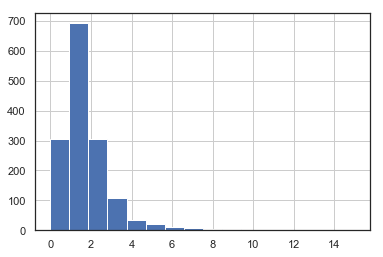

In [608]:
# one bin for each frequency bucket
X_train['Freq'].hist(bins = 16);

Depending on the initial performance, we may want to consider a transformation for frequency.

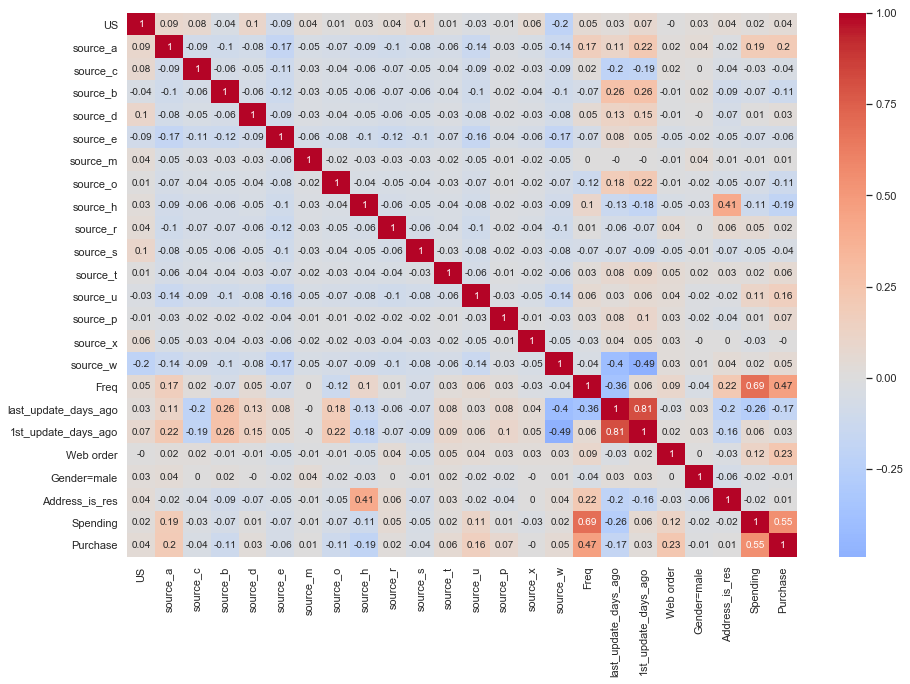

In [338]:
# combine train X,y sets for correlation
corr = pd.concat([X_train, y_train], axis = 1).corr()

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr.round(2), 
            center = 0,
            cmap = 'coolwarm',
            annot = True);

Some interesting observations of our correlation analysis:
+ Source A & U are positively associated with purchase and spending
+ Source H is negatively associated with purchase and spending
+ Source H is correlated with residential addresses, so maybe our target is non-residential customers

## Prototype

First we will create a dummy classifier and regressor to understand what our baseline metrics are to improve. Our overall goal isn't to create a perfect classifier and regressor, but to identify which customers we can expect more value from to use to rank and target. 

In [339]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

dummy_cf = DummyClassifier(strategy = 'uniform', random_state = 1)
dummy_cv_acc = cross_val_score(dummy_cf, X_train, 
                               y_train['Purchase'], 
                               scoring = 'accuracy',
                               cv = 5)
print(f"Baseline accuracy: {np.mean(dummy_cv_acc) * 100:.2f}%")

Baseline accuracy: 51.94%


In [340]:
# filter for just spenders from variable above
y_train_reg = y_train[spenders]['Spending']
X_train_reg = X_train.loc[spenders]

In [603]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy = 'mean')
dummy_cv_mse = cross_val_score(dummy_reg, X_train_reg, 
                               np.log(y_train_reg), 
                               scoring = 'neg_mean_squared_error',
                               cv = 5)

dummy_rmse = np.sqrt(-dummy_cv_mse)

print(f"Baseline RMSE: ${np.mean(dummy_rmse):.2f}")

Baseline RMSE: $0.94


#### Classification

In [342]:
from sklearn.linear_model import LogisticRegression

# develop simple model pipeline
logit = LogisticRegression()
logit_cv_acc = cross_val_score(logit, X_train, 
                               y_train['Purchase'], 
                               scoring = 'accuracy',
                               cv = 10)
print(f"Model accuracy: {np.mean(logit_cv_acc) * 100:.2f}% +- {np.std(logit_cv_acc) * 100:.2F}%")

Model accuracy: 80.87% +- 2.71%


The standard logistic regression provides decent accuracy over the cross-validation. We can use a grid search to see if we can improve that with different hyperparameters.

In [343]:
from sklearn.model_selection import GridSearchCV

np.random.seed(1)

# hyperparameters
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 0.5, 1, 10, 100, 1000, 1e9]

# create dictionary to search
hyperparamters = dict(C = C, penalty = penalty)

gridsearch = GridSearchCV(
    logit, hyperparamters, scoring = 'accuracy', cv = 10, verbose = 0
)

best_logit = gridsearch.fit(X_train, y_train['Purchase'])

print('Best Penalty:', best_logit.best_estimator_.get_params()['penalty'])
print('Best C:', best_logit.best_estimator_.get_params()['C'])
print('Best Score:', best_logit.best_score_.round(2))

Best Penalty: l2
Best C: 1
Best Score: 0.81


We see that there is no real improvement with other hyperparameters and can proceed with the standard logit model. 80% accuracy seems good enough for now, so we can proceed to our regression task. 

Note: A potential opportunity for improvement would be to try other algorithms, or even use H2O AutoML to select the best model for us to maximize accuracy. For the sake of time, we will proceed with our logit results.

In [344]:
from sklearn.linear_model import LinearRegression

# develop simple model pipeline
ols = LinearRegression()
ols.fit(X_train_reg, np.log(y_train_reg))
ols_cv_mse = cross_val_score(ols, X_train_reg, 
                             np.log(y_train_reg), 
                             scoring = 'neg_mean_squared_error',
                             cv = 10)
ols_rmse = np.sqrt(-ols_cv_mse)

print(f"OLS RMSE: {np.mean(ols_rmse):.2f}")

OLS RMSE: 0.80


Our standard OLS model provides some improvement over baseline. We can try a tree model and grid search to see if we get any improvement. The goal here is just to identify the potential high spenders so that we rank them higher in the target distribution.

In [604]:
from sklearn.tree import DecisionTreeRegressor

# develop simple model pipeline
tree = DecisionTreeRegressor(random_state = 1)
tree_cv_mse = cross_val_score(tree, X_train_reg, 
                             np.log(y_train_reg), 
                             scoring = 'neg_mean_squared_error',
                             cv = 10)
tree_rmse = np.sqrt(-tree_cv_mse)

print(f"Tree RMSE: ${np.mean(tree_rmse):.2f}")

Tree RMSE: $1.01


In [605]:
from sklearn.tree import DecisionTreeRegressor

# hyperparamters
criterion = ["mse", "mae"]
min_samples_split = [2, 5, 10, 20, 40]
max_depth = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 5, 10, 20, 40, 100]
max_leaf_nodes = [2, 5, 10, 20, 100]

# create dictionary to search
hyperparamters = dict(criterion = criterion,
                      min_samples_split = min_samples_split,
                      max_depth = max_depth,
                      min_samples_leaf = min_samples_leaf,
                      max_leaf_nodes = max_leaf_nodes)

gridsearch = GridSearchCV(
    tree, hyperparamters, scoring = 'neg_mean_squared_error',
    cv = 10, verbose = 0
)

best_tree = gridsearch.fit(X_train_reg, np.log(y_train_reg))
print('Best Criterion:', best_tree.best_estimator_.get_params()['criterion'])
print('Best Min Samples Depth:', best_tree.best_estimator_.get_params()['min_samples_split'])
print('Best Max Depth:', best_tree.best_estimator_.get_params()['max_depth'])
print('Best Min Samples Leaf:', best_tree.best_estimator_.get_params()['min_samples_leaf'])
print('Best Max Leaf Nodes:', best_tree.best_estimator_.get_params()['max_leaf_nodes'])
print('Best Score:', np.sqrt(-best_tree.best_score_).round(2))

Best Criterion: mse
Best Min Samples Depth: 2
Best Max Depth: 4
Best Min Samples Leaf: 10
Best Max Leaf Nodes: 10
Best Score: 0.82


Even after a grid search across several different hyperparamenters, the tree model doesn't out-perform the OLS model. For now, we can stick with the simpler model and proceed with performance testing. 

NOTE: If we needed improvement, we could try other models like Support Vectors , or even let H2O AutoML select the best model for us. 

## Test & Implement

First we will generate the predictions on the test set and then rank customers in the test set by their expected profitability (predicted purchase probability * predicted spend - cost of targeting). 

Then we will evaluate the performance of different deciles and simulate potential performance if customers in the top deciles were targeted. The final output of this will be an expected range of profitability from targeting the top 180,000 scored customers. We'll base ur projected improvement using the 5% percentile of the simulations to taper expectations of performance (i.e., 95% of the simulations performed better than the numbers we will report).

In [376]:
# generate probability of purchase
y_test['pred_purchase'] = best_logit.predict_proba(X_test)[:,1]

# generate predicted log spend
y_test['pred_logspend'] = ols.predict(X_test)

# transform predictions
y_test['adjust_purchase_prob'] = y_test['pred_purchase'] * 0.107
y_test['pred_spend'] = np.exp(y_test['pred_logspend'])

# create expected value
y_test['expected_value'] = y_test['pred_spend'] * y_test['adjust_purchase_prob']
y_test['expected_profit'] = y_test['expected_value'] - 2

# actual profit
y_test['actual_profit'] = y_test['Spending'] - 2


y_test['rank'] = (len(y_test) + 1) - y_test['expected_profit'].rank(method = 'first').astype(int)

y_test['cumulative_profit'] = y_test.sort_values('rank', ascending = True)['actual_profit'].cumsum()

In [609]:
y_test.sort_values('rank', ascending = True).head()

,Spending,Purchase,pred_purchase,pred_logspend,adjust_purchase_prob,pred_spend,expected_value,expected_profit,actual_profit,rank,cumulative_profit,decile
sequence_number,,,,,,,,,,,,
618,1195,1,1.000000,7.756927,0.107000,2337.708962,250.134859,248.134859,1193,1,1193,1
835,1441,1,1.000000,7.668173,0.107000,2139.169966,228.891186,226.891186,1439,2,2632,1
1455,456,1,0.999159,6.081383,0.106910,437.634093,46.787481,44.787481,454,3,3086,1
1433,271,1,0.999808,6.028108,0.106979,414.929303,44.388919,42.388919,269,4,3355,1
553,585,1,0.999834,6.025179,0.106982,413.715785,44.260238,42.260238,583,5,3938,1


In [610]:
y_test.sort_values('rank', ascending = True).tail()

,Spending,Purchase,pred_purchase,pred_logspend,adjust_purchase_prob,pred_spend,expected_value,expected_profit,actual_profit,rank,cumulative_profit,decile
sequence_number,,,,,,,,,,,,
531,0,0,0.020586,4.624082,0.002203,101.909166,0.224473,-1.775527,-2,496,51783,10
430,0,0,0.028341,4.303632,0.003032,73.967971,0.224303,-1.775697,-2,497,51781,10
1820,0,0,0.020572,4.623587,0.002201,101.858745,0.224216,-1.775784,-2,498,51779,10
758,0,0,0.035068,3.958851,0.003752,52.397082,0.196609,-1.803391,-2,499,51777,10
781,0,0,0.010397,3.473174,0.001112,32.238918,0.035864,-1.964136,-2,500,51775,10


After getting our test data performance calculated, we can view the summary statitics of the test data variables. 

In [380]:
y_test.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Spending,500.0,105.55,186.12,0.00,0.00,28.50,159.25,1441.00
Purchase,500.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
pred_purchase,500.0,0.52,0.33,0.01,0.19,0.54,0.82,1.00
pred_logspend,500.0,4.66,0.47,3.47,4.39,4.66,4.89,7.76
adjust_purchase_prob,500.0,0.06,0.04,0.00,0.02,0.06,0.09,0.11
pred_spend,500.0,123.54,146.05,32.24,80.25,105.42,132.77,2337.71
expected_value,500.0,8.66,16.65,0.04,1.99,5.42,10.58,250.13
expected_profit,500.0,6.66,16.65,-1.96,-0.01,3.42,8.58,248.13
actual_profit,500.0,103.55,186.12,-2.00,-2.00,26.50,157.25,1439.00
rank,500.0,250.50,144.48,1.00,125.75,250.50,375.25,500.00


#### Performance Evaluation

In [451]:
# compute confusion matrix
pd.crosstab(y_test['Purchase'], 
            np.where(y_test['pred_purchase'] > .5, 1, 0), 
            rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,196,47,243
1,47,210,257
All,243,257,500


In [614]:
test_accuracy = (y_test['Purchase'] == np.where(y_test['pred_purchase'] > .5, 1, 0)).mean()

print("Test Set Accuracy:", test_accuracy)

Test Set Accuracy: 0.812


We see our test set has an accuracy of 81% which is very similar to our training cross-validation performance. 

In [406]:
# add deciles
y_test['decile'] = pd.qcut(y_test['expected_profit'], 10, labels = range(10,0,-1)).astype(int)

In [407]:
y_test.head()

,Spending,Purchase,pred_purchase,pred_logspend,adjust_purchase_prob,pred_spend,expected_value,expected_profit,actual_profit,rank,cumulative_profit,decile
sequence_number,,,,,,,,,,,,
1861,105,1,0.603194,4.938441,0.064542,139.552474,9.006963,7.006963,103,161,37670,4
354,25,1,0.789013,4.719226,0.084424,112.081519,9.462418,7.462418,23,150,36516,3
1334,161,1,0.624590,4.562167,0.066831,95.790809,6.401804,4.401804,159,226,43493,5
906,130,1,0.231869,4.367560,0.024810,78.851008,1.956296,-0.043704,128,376,51103,8
1290,0,0,0.062616,4.345628,0.006700,77.140445,0.516834,-1.483166,-2,439,51897,9


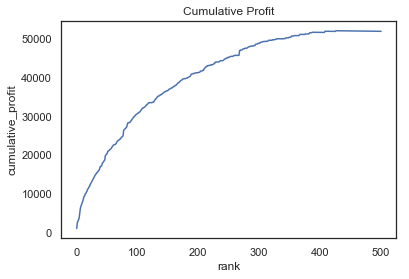

In [617]:
ax = sns.lineplot(x = "rank", y = "cumulative_profit",
             data = y_test)
ax.set_title("Cumulative Profit");

We can then group our data by the decile ranking (based on expected profit) to see how performance varies across the sample. 

In [429]:
y_test_grp_sum = y_test.groupby('decile').sum().reset_index()
y_test_grp_avg = y_test.groupby('decile').mean().reset_index()

y_test_grp_avg['avg_expected_profit'] = y_test_grp_avg['adjust_purchase_prob'] * \
                                            y_test_grp_avg['Spending']

Below we see that the top two deciles contain the most profitable customers. 

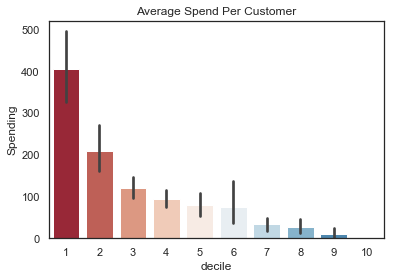

In [442]:
ax = sns.barplot(x = "decile", y = "Spending", data = y_test, palette = "RdBu")
ax.set_title("Average Spend Per Customer");

Additionally, the top four deciles have the highest percentage of purchasers. There do not appear to be any purchasers in the last decile. 

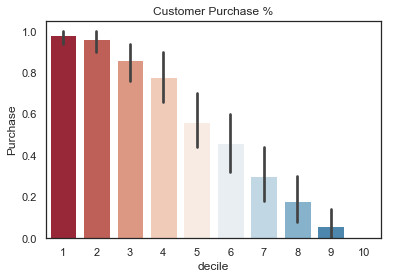

In [441]:
ax = sns.barplot(x = "decile", y = "Purchase", data = y_test, palette = "RdBu")
ax.set_title("Customer Purchase %");

As a result, the top decile by far has the most total profit, which deciles two and three having a good amount of profit. 

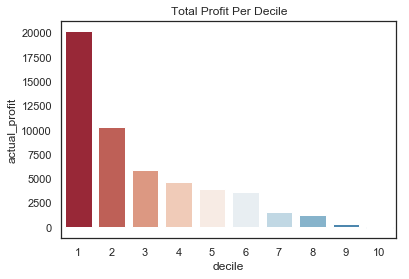

In [428]:
ax = sns.barplot(x = "decile", y = "actual_profit", data = y_test_grp_sum, palette = "RdBu")
ax.set_title("Total Profit Per Decile");

Using the baseline profit per customer (dashed line), we see an increase in expected profit per customer over the baseline in the top three deciles. The second chart shows the top decile has an expected lift of almost 5x over the baseline of a random send. The second decile has a lift of over 2x. While we need only the top 3.6% of customers, we could score and target the top 30% and expect to do better than randomly targeting customers.

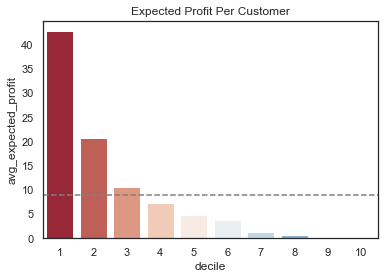

In [437]:
# from objective 1 
random_expected_per_customer = random_gross_profit / sendout_size

ax = sns.barplot(x = "decile", y = "avg_expected_profit", data = y_test_grp_avg, palette = "RdBu")
ax.axhline(random_expected_per_customer, ls = '--', c = "grey")
ax.set_title("Expected Profit Per Customer");

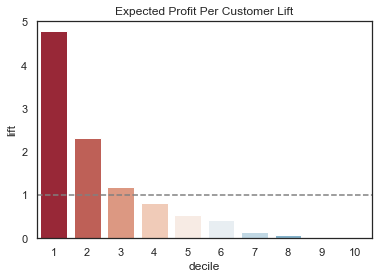

In [439]:
y_test_grp_avg['lift'] = y_test_grp_avg['avg_expected_profit'] / random_expected_per_customer

ax = sns.barplot(x = "decile", y = "lift", data = y_test_grp_avg, palette = "RdBu")
ax.axhline(1, ls = '--', c = "grey")
ax.set_title("Expected Profit Per Customer Lift");

#### Expected Gross Profit of Targeted Sendout

To get a better idea of the profit potential, we will simulate a bunch of sendouts targeting the top 20% of our test dataset and record the profit of each trial sendout. This will give us an idea of the potential profit distribution. 

For each trial, we will bootstrap sample 180,000 customers from the top two deciles. Then for each customer, we will simulate whether or not they make a purchase based on their adjusted purchase probability. If they make a purchase, we will record the amount they spend in the test sendout. We then will subtract the cost of targeting them (-\\$360,000 in total). Then we will record the total profit. Then repeat for k total simulation trials. 

In [556]:
# only top 20% of customers are selected
top_deciles = y_test['decile'] <= 2

# create sampling frame of selected customers
sample_cols = ['Spending', 'adjust_purchase_prob']
sample_frame = y_test.loc[top_deciles, sample_cols]

# generate sample of sample_size customers from sample frame
# return sum of profit from sample
def sendout_simulation_trial(sample_size):
    sample = sample_frame.sample(n = sample_size, replace = True)
    sample['Purchase'] = np.random.binomial(1, sample['adjust_purchase_prob'])
    sample['profit'] = (sample['Purchase'] * sample['Spending']) - 2
    return sample['profit'].sum()

# run num_trials simulations of the targeted sendout simulation
def sendout_simulations(num_trials, sample_size):
    sendout_profits = []

    for _ in range(num_trials):
        expected_profit = sendout_simulation_trial(sample_size)
        sendout_profits.append(expected_profit)
        
    return sendout_profits

In [557]:
num_trials = 5000

simulated_profits = sendout_simulations(num_trials, sendout_size)

simulation_df = pd.DataFrame(index = range(num_trials), 
                             data = {'Profit': simulated_profits})

After running 5000 trials, we can look at the summary statistics of the expected profit.

In [558]:
simulation_df.describe().round(0)

,Profit
count,5000.0
mean,5377974.0
std,55264.0
min,5170038.0
25%,5340153.0
50%,5377504.0
75%,5414184.0
max,5574109.0


We can also plot the distribution of outcomes. We see most of our values are between 5.2 and 5.5 million dollars. 

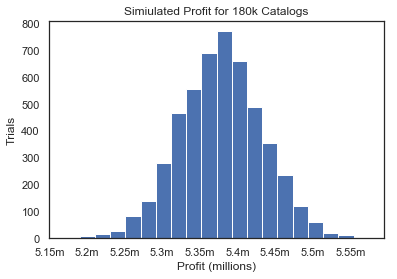

In [569]:
fig, ax = plt.subplots()
simulation_df['Profit'].plot.hist(bins = 20)
plt.title(f'Simiulated Profit for {sendout_size / 1e3:.0F}k Catalogs')
plt.xlabel('Profit (millions)')
plt.ylabel('Trials')
x_labels = ax.get_xticks()
ax.set_xticklabels([str(x / 1e6) + "m" for x in x_labels]);

Lastly, we will use the low end of the 95% confidence interval to report on our performance expectations of a full sendout. Given the assumptions of our modeling exercise and simulations, we have our expected profit, lift, and estimated value of the data science approach to marketing. 

In [616]:
pct_95_val = simulation_df['Profit'].quantile([.05]).values[0]

pct_95_profit_per_customer = pct_95_val / sendout_size

pct_95_lift = pct_95_profit_per_customer / random_expected_per_customer - 1

print('Targeted Marketing Simulation Results (95% Confidence)')
print('------------------------------------------------------')
print(f'Expected profit: ${pct_95_val / 1e6:.2F}m')
print(f'Expected lift: {pct_95_lift * 100:.0F}% increase in profit per customer over baseline')
print(f'Expected added value of Data Science: ${(pct_95_val - random_gross_profit) / 1e6:.2F}m')

Targeted Marketing Simulation Results (95% Confidence)
------------------------------------------------------
Expected profit: $5.29m
Expected lift: 229% increase in profit per customer over baseline
Expected added value of Data Science: $3.68m


#### Deploy

To deploy this model, we can pickle the logit and OLS prediction models and score the remaining 4.98 million customers. The top 180,000 customers will then be provided to the marketing team to target with catalogs.

Since this is a one-time exercise, we do not need to worry about automating the model training and scoring process.

## Improve

While we appear to have found a method to deliver value to the business, there are a few ways that we could improve upon the method we selected.

+ First, we could work to improve our model through additional feature engineering or algorithm selection. We could use k-nn or k-means clustering to add a variable to the dataset that gathers more local information. If we are worried about data leakage, we could use another partition of the dataset to train the k-nn or k-means model. In terms of algorithm selection, we could either test additional algorithms on our data to improve the classification or regression step, and/or stack a few models together for a more accurate prediction.

+ While the goal is to only target the next 180,000 customers, we could explore contributing more customers to the pool so that we could pull more customers out to target. Theoretically, there are another 25% of customers we could target with an increased lift over selection at random. 

+ We chose a quick and dirty method to score and rank customers to target. There is opportunity to dive further into the correlation analysis we did and uncover potential partnerships or customer affinities based on the sources that are more likely to respond to a catalog and spend a lot. For example, we could re-run a logisitc regression model in either base R or the statsmodel package and check which sources are statistically significant for purchasing and spend. This will help us understand which cross-over customer we might have with other catalogs and enrich our customer understanding. Additionally, we could look for paid advertising within their catalogs if their customers are most likely to want to purchase from us. 

+ One other method we could use to better understand our customers is customer segmentation. We can use clustering techniques to form meaning groups and target them based on any known affinities of the overall group. We could then find additional opportunities for custom catalogs to target different groups of customers. 